In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from sklearn.metrics import root_mean_squared_error as rmse

import sys
sys.path.append('../Script/')
from LithiumStochastic import  calc_RLisw_steady

In [2]:
# Load New Li loess
target_df = pd.read_csv('../Output/Ordovician_Li_Loess.csv')

age = target_df['Age'].to_numpy(),
d7Lisw = target_df.d7Li.to_numpy()+5.5

# Unload numpy array from tupple
age = age[0]

In [3]:
fsr = pd.read_csv('../Data/Model/seafloor_production.csv')
fsr['Fh'] = fsr['fsr'] * 13

# Resample Fh
f = interp1d(fsr.age, fsr.Fh)
Fh_model = f(age)

In [4]:
d7Li_df = pd.read_csv('../Data/Lithium/Ordovician_Lithium_Composite_Final.csv')
d7Li_loess_df = pd.read_csv('../Output/Ordovician_Li_Loess.csv')

# Bells and whistles for plotting
markers = ["o", "h", "^"]
colors = ['maroon', 'gray']

locality = [ 'Ibex', 'Shingle Pass']

locality_unc = ['Antelope Range',
 'Meiklejohn Peak', 'Clear Spring', 'Germany Valley']

colors_unc = [ 'maroon', 'gray','steelblue', 'teal']
markers_unc = [ 'd', "s", "^", "<"]

ordo = pd.DataFrame({
    'epoch' : ['Early', 'Middle', 'Late'],
    'lower_boundary' : [486.85, 471.26, 458.18],
    'upper_boundary' : [471.26, 458.18, 455],
    'color' : ['#1A9D6F', '#4DB47E', '#7FCA93']
})

In [5]:
# Define Equation to solve for Rriv and Friv
def solve_riverine(riv):
    # Unpack riv into Flux (Friv) and ratios (Rriv)
    Friv, Rriv = riv
    # Steady state mass balance - eq = input - output
    eq1 = Friv + Fh - Fsed - Falt
    eq2 = Friv*Rriv + Fh*Rh - Falt*(Rsw-Dalt) - Fsed*(Rsw-Dsed)
    return [eq1, eq2]

In [6]:
# Constant everything at modern values
Fh = 13
Rh = 8.3
Falt = 12
Dalt = 13
Fsed = 11
Dsed = 20

Friv_sol =[]
Rriv_sol = []

for i in range(len(age)):
    Rsw = d7Lisw[i]
    Fh = Fh_model[i]
    initial_guess = [5, 13]
    solution = fsolve(solve_riverine, initial_guess)

    Friv_sol.append(solution[0])
    Rriv_sol.append(solution[1])

In [7]:
Friv_sol_array = np.array(Friv_sol)
Rriv_sol_array = np.array(Rriv_sol)


Rh_array = np.ones_like(age)*Rh
Falt_array = np.ones_like(age)*Falt
Dalt_array = np.ones_like(age)*Dalt
Fsed_array = np.ones_like(age)*Fsed
Dsed_array = np.ones_like(age)*Dsed


Rsw_ss = calc_RLisw_steady(Friv_sol_array, Rriv_sol_array, Fh_model, Rh_array,
                           Fsed_array, Dsed_array, Falt_array, Dalt_array)

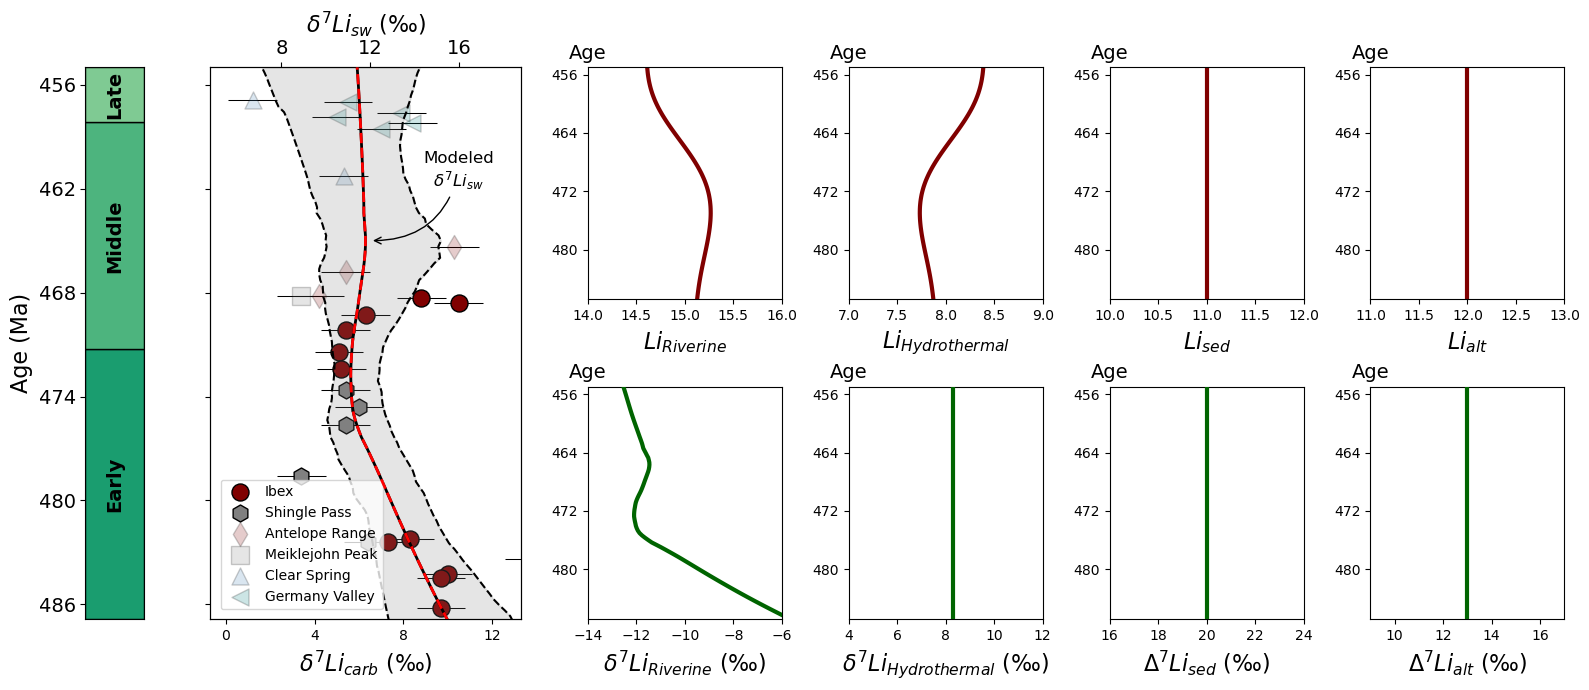

In [8]:
# Plotting Data
# Plot d7Li data
fig = plt.figure(figsize=(16, 7))

# width and height ratios
w = [0.3, 1.6, 1, 1, 1, 1 ]
h = [1, 1]

# Gridspec
gs = fig.add_gridspec(ncols=6, nrows=2, width_ratios=w, height_ratios=h)

# Axes
ax0 = fig.add_subplot(gs[0:,0])
ax = fig.add_subplot(gs[0:,1], sharey=ax0)

ax1 = fig.add_subplot(gs[0,2])
ax2 = fig.add_subplot(gs[1,2])

ax3 = fig.add_subplot(gs[0,3], sharey=ax1)
ax4 = fig.add_subplot(gs[1,3], sharey=ax2)

ax5 = fig.add_subplot(gs[0,4], sharey=ax1)
ax6 = fig.add_subplot(gs[1,4], sharey=ax2)

ax7 = fig.add_subplot(gs[0,5], sharey=ax1)
ax8 = fig.add_subplot(gs[1,5], sharey=ax2)

# Plot Ordovician Period
trans = ax0.get_yaxis_transform()
ordo['h'] = ordo['lower_boundary'] - ordo['upper_boundary']
rot = [90, 90, 90]
for ind in ordo.index:
    ax0.add_patch(Rectangle(xy=[0, ordo['upper_boundary'][ind]],
                            width=1,
                            height=ordo['h'][ind],
                            transform=trans, ec='black',
                            fc=ordo['color'][ind]))
    
    ax0.text(0.5, ordo['lower_boundary'][ind]-0.5*ordo['h'][ind], 
                str(ordo['epoch'][ind]), rotation=rot[ind],
                horizontalalignment='center', verticalalignment='center',
                transform = trans, fontsize=14, fontweight='bold')

# Plot d7Li data
for i, s in enumerate(locality):
    ax.scatter(d7Li_df['d7Li'].loc[d7Li_df.Locality == s], 
                d7Li_df['Age'].loc[d7Li_df.Locality == s],
                fc=colors[i],
                ec='k',
                s=150,
                marker=markers[i], label=s)

for i, s in enumerate(locality_unc):
    ax.scatter(d7Li_df['d7Li'].loc[d7Li_df.Locality == s], 
                d7Li_df['Age'].loc[d7Li_df.Locality == s],
                fc=colors_unc[i],
                ec='k',
                s=150,
                marker=markers_unc[i], label=s, alpha=0.2)

ax.legend(fontsize=10, loc='lower left', 
            bbox_to_anchor=(0.01, 0.005),
            title_fontsize=12)

ax.set_ylim(486.85, 455)

xmin = -0.7
xmax = 13.3
ax.set_xlim(xmin, xmax)

axt = ax.twiny()
axt.set_xlim(xmin+5.5, xmax+5.5)
axt.set_xlabel('$\delta^{7}Li_{sw}$ (‰)', fontsize=16)
axt.xaxis.set_major_locator(plt.MaxNLocator(4))
axt.tick_params(axis='x', labelsize=14)

ax.errorbar(d7Li_df['d7Li'], d7Li_df['Age'], xerr=1.1, fmt='none', ecolor='k',
             elinewidth=0.75, zorder=-3)

# Plot d7Li lowess
ax.plot(d7Li_loess_df['d7Li'], d7Li_loess_df['Age'], 'k-', lw=2, zorder=3)
ax.plot(d7Li_loess_df['upper95'], d7Li_loess_df['Age'], 'k--')
ax.plot(d7Li_loess_df['lower95'], d7Li_loess_df['Age'], 'k--')
ax.fill_betweenx(d7Li_loess_df['Age'], d7Li_loess_df['upper95'], 
                  d7Li_loess_df['lower95'], color='grey', alpha=0.2)

axt.plot(Rsw_ss, age, 'r--', lw=2, zorder=3)

ax0.tick_params(axis='x', bottom=False, labelbottom=False)
ax0.set_ylabel('Age (Ma)', fontsize=16)
ax0.yaxis.set_major_locator(plt.MaxNLocator(6))
ax0.tick_params(axis='y', labelsize=14)


ax.set_xlabel('$\delta^{7}Li_{carb}$ (‰)', fontsize=16)


# Model Results
# Plot Fr data
ax1.plot(Friv_sol_array, age, c='maroon', lw=3)

ax1.set_ylim(486.85, 455)
ax1.set_xlabel('$Li_{Riverine}$', fontsize=16)
# ax1.set_xlim(4e9, 9.5e9)


# Plot Rr data
ax2.plot(Rriv_sol_array, age, lw=3, c='darkgreen', zorder=3)
ax2.set_ylim(486.85, 455)
ax2.set_xlabel('$\delta^7Li_{Riverine}$ (‰)', fontsize=16)


# Plot Fh
ax3.plot(Fh_model, age, c='maroon', lw=3)
ax3.set_xlabel('$Li_{Hydrothermal}$', fontsize=16)

# Plot Rh data
ax4.plot(np.ones_like(age)*Rh, age, lw=3, c='darkgreen', zorder=3)
ax4.set_xlabel('$\delta^7Li_{Hydrothermal}$ (‰)', fontsize=16)



# Plot Fsed
ax5.plot(np.ones_like(age)*Fsed, age, c='maroon', lw=3)
ax5.set_xlabel('$Li_{sed}$', fontsize=16)


# Plot Dsed data
ax6.plot(np.ones_like(age)*Dsed, age, lw=3, c='darkgreen', zorder=3)
ax6.set_xlabel('$\Delta^7Li_{sed}$ (‰)', fontsize=16)
# ax4.set_xlim(3, 16)


# Plot Falt
ax7.plot(np.ones_like(age)*Falt, age, c='maroon', lw=3)
ax7.set_xlabel('$Li_{alt}$', fontsize=16)


# Plot Dalt data
ax8.plot(np.ones_like(age)*Dalt, age, lw=3, c='darkgreen', zorder=3)
ax8.set_xlabel('$\Delta^7Li_{alt}$ (‰)', fontsize=16)

for axs in [ax]:
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.tick_params(axis='y', labelleft=False)
    

for axs in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.yaxis.set_major_locator(plt.MaxNLocator(4))
    axs.set_ylabel('Age', fontsize=14, rotation=0)
    axs.yaxis.set_label_coords(0,1.02)


ax1.set_xlim(14, 16)
ax3.set_xlim(7, 9)
ax5.set_xlim(10, 12)
ax7.set_xlim(11, 13)


ax2.set_xlim(-14, -6)
ax4.set_xlim(4, 12)
ax6.set_xlim(16, 24)
ax8.set_xlim(9, 17)

# Annotation
axt.annotate("Modeled\n$\delta^7Li_{sw}$",
            xy=(12, 465), xycoords='data',
            xytext=(16, 461), textcoords='data',
            size=12, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.4"))

fig.tight_layout()

plt.savefig('../Figure/Model_Deterministic_Inverse_modern.png', dpi=300)
plt.savefig('../Figure/Model_Deterministic_Inverse_modern.svg')

In [9]:
# Constant everything lower fractionation for Dalt and Dsed
Rh = 8.3
Falt = 12
Dalt = 8
Fsed = 11
Dsed = 8

Friv_sol =[]
Rriv_sol = []

for i in range(len(age)):
    Rsw = d7Lisw[i]
    Fh = Fh_model[i]
    initial_guess = [6, 15]
    solution = fsolve(solve_riverine, initial_guess)

    Friv_sol.append(solution[0])
    Rriv_sol.append(solution[1])


Friv_sol_array = np.array(Friv_sol)
Rriv_sol_array = np.array(Rriv_sol)



C:\Users\datua\AppData\Local\Temp\ipykernel_12272\4259194639.py:15: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(solve_riverine, initial_guess)


In [10]:
Rh_array = np.ones_like(age)*Rh
Falt_array = np.ones_like(age)*Falt
Dalt_array = np.ones_like(age)*Dalt
Fsed_array = np.ones_like(age)*Fsed
Dsed_array = np.ones_like(age)*Dsed


Rsw_ss = calc_RLisw_steady(Friv_sol_array, Rriv_sol_array, Fh_model, Rh_array,
                           Fsed_array, Dsed_array, Falt_array, Dalt_array)

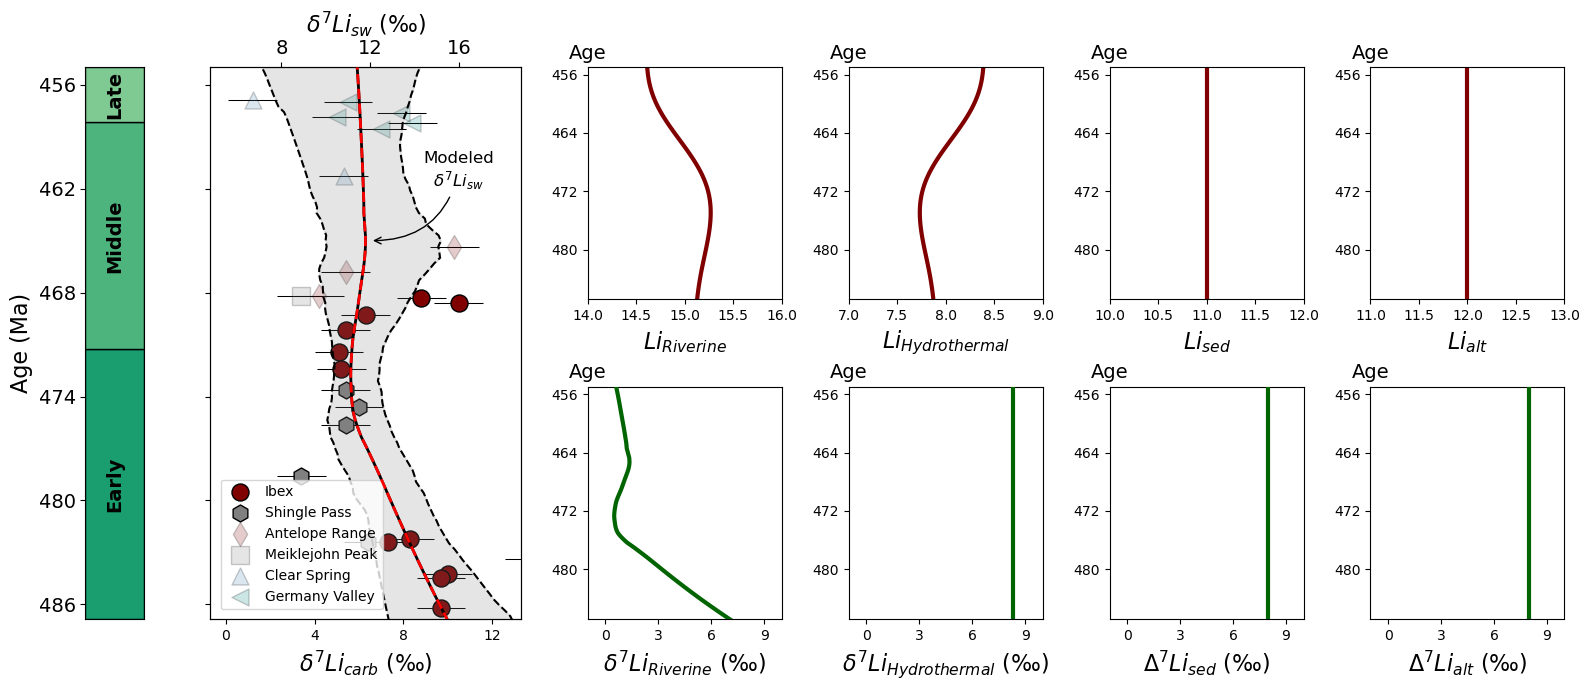

In [11]:
# Plotting Data
# Plot d7Li data
fig = plt.figure(figsize=(16, 7))

# width and height ratios
w = [0.3, 1.6, 1, 1, 1, 1 ]
h = [1, 1]

# Gridspec
gs = fig.add_gridspec(ncols=6, nrows=2, width_ratios=w, height_ratios=h)

# Axes
ax0 = fig.add_subplot(gs[0:,0])
ax = fig.add_subplot(gs[0:,1], sharey=ax0)

ax1 = fig.add_subplot(gs[0,2])
ax2 = fig.add_subplot(gs[1,2])

ax3 = fig.add_subplot(gs[0,3], sharey=ax1)
ax4 = fig.add_subplot(gs[1,3], sharey=ax2)

ax5 = fig.add_subplot(gs[0,4], sharey=ax1)
ax6 = fig.add_subplot(gs[1,4], sharey=ax2)

ax7 = fig.add_subplot(gs[0,5], sharey=ax1)
ax8 = fig.add_subplot(gs[1,5], sharey=ax2)

# Plot Ordovician Period
trans = ax0.get_yaxis_transform()
ordo['h'] = ordo['lower_boundary'] - ordo['upper_boundary']
rot = [90, 90, 90]
for ind in ordo.index:
    ax0.add_patch(Rectangle(xy=[0, ordo['upper_boundary'][ind]],
                            width=1,
                            height=ordo['h'][ind],
                            transform=trans, ec='black',
                            fc=ordo['color'][ind]))
    
    ax0.text(0.5, ordo['lower_boundary'][ind]-0.5*ordo['h'][ind], 
                str(ordo['epoch'][ind]), rotation=rot[ind],
                horizontalalignment='center', verticalalignment='center',
                transform = trans, fontsize=14, fontweight='bold')

# Plot d7Li data
for i, s in enumerate(locality):
    ax.scatter(d7Li_df['d7Li'].loc[d7Li_df.Locality == s], 
                d7Li_df['Age'].loc[d7Li_df.Locality == s],
                fc=colors[i],
                ec='k',
                s=150,
                marker=markers[i], label=s)

for i, s in enumerate(locality_unc):
    ax.scatter(d7Li_df['d7Li'].loc[d7Li_df.Locality == s], 
                d7Li_df['Age'].loc[d7Li_df.Locality == s],
                fc=colors_unc[i],
                ec='k',
                s=150,
                marker=markers_unc[i], label=s, alpha=0.2)

ax.legend(fontsize=10, loc='lower left', 
            bbox_to_anchor=(0.01, 0.005),
            title_fontsize=12)

ax.set_ylim(486.85, 455)

xmin = -0.7
xmax = 13.3
ax.set_xlim(xmin, xmax)

axt = ax.twiny()
axt.set_xlim(xmin+5.5, xmax+5.5)
axt.set_xlabel('$\delta^{7}Li_{sw}$ (‰)', fontsize=16)
axt.xaxis.set_major_locator(plt.MaxNLocator(4))
axt.tick_params(axis='x', labelsize=14)

ax.errorbar(d7Li_df['d7Li'], d7Li_df['Age'], xerr=1.1, fmt='none', ecolor='k',
             elinewidth=0.75, zorder=-3)

# Plot d7Li lowess
ax.plot(d7Li_loess_df['d7Li'], d7Li_loess_df['Age'], 'k-', lw=2, zorder=3)
ax.plot(d7Li_loess_df['upper95'], d7Li_loess_df['Age'], 'k--')
ax.plot(d7Li_loess_df['lower95'], d7Li_loess_df['Age'], 'k--')
ax.fill_betweenx(d7Li_loess_df['Age'], d7Li_loess_df['upper95'], 
                  d7Li_loess_df['lower95'], color='grey', alpha=0.2)

axt.plot(Rsw_ss, age, 'r--', lw=2, zorder=3)

ax0.tick_params(axis='x', bottom=False, labelbottom=False)
ax0.set_ylabel('Age (Ma)', fontsize=16)
ax0.yaxis.set_major_locator(plt.MaxNLocator(6))
ax0.tick_params(axis='y', labelsize=14)


ax.set_xlabel('$\delta^{7}Li_{carb}$ (‰)', fontsize=16)


# Model Results
# Plot Fr data
ax1.plot(Friv_sol_array, age, c='maroon', lw=3)

ax1.set_ylim(486.85, 455)
ax1.set_xlabel('$Li_{Riverine}$', fontsize=16)
# ax1.set_xlim(4e9, 9.5e9)


# Plot Rr data
ax2.plot(Rriv_sol_array, age, lw=3, c='darkgreen', zorder=3)
ax2.set_ylim(486.85, 455)
ax2.set_xlabel('$\delta^7Li_{Riverine}$ (‰)', fontsize=16)


# Plot Fh
ax3.plot(Fh_model, age, c='maroon', lw=3)
ax3.set_xlabel('$Li_{Hydrothermal}$', fontsize=16)

# Plot Rh data
ax4.plot(np.ones_like(age)*Rh, age, lw=3, c='darkgreen', zorder=3)
ax4.set_xlabel('$\delta^7Li_{Hydrothermal}$ (‰)', fontsize=16)



# Plot Fsed
ax5.plot(np.ones_like(age)*Fsed, age, c='maroon', lw=3)
ax5.set_xlabel('$Li_{sed}$', fontsize=16)


# Plot Dsed data
ax6.plot(np.ones_like(age)*Dsed, age, lw=3, c='darkgreen', zorder=3)
ax6.set_xlabel('$\Delta^7Li_{sed}$ (‰)', fontsize=16)
# ax4.set_xlim(3, 16)


# Plot Falt
ax7.plot(np.ones_like(age)*Falt, age, c='maroon', lw=3)
ax7.set_xlabel('$Li_{alt}$', fontsize=16)


# Plot Dalt data
ax8.plot(np.ones_like(age)*Dalt, age, lw=3, c='darkgreen', zorder=3)
ax8.set_xlabel('$\Delta^7Li_{alt}$ (‰)', fontsize=16)

for axs in [ax]:
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.tick_params(axis='y', labelleft=False)
    

for axs in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.yaxis.set_major_locator(plt.MaxNLocator(4))
    axs.set_ylabel('Age', fontsize=14, rotation=0)
    axs.yaxis.set_label_coords(0,1.02)

for axs in [ax2, ax4, ax6, ax8]:
    axs.set_xlim(-1, 10)

# for axs in [ax1, ax3, ax5, ax7]:
#     axs.set_xlim(7, 16)

ax1.set_xlim(14, 16)
ax3.set_xlim(7, 9)
ax5.set_xlim(10, 12)
ax7.set_xlim(11, 13)

# Annotation
axt.annotate("Modeled\n$\delta^7Li_{sw}$",
            xy=(12, 465), xycoords='data',
            xytext=(16, 461), textcoords='data',
            size=12, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.4"))

fig.tight_layout()


plt.savefig('../Figure/Model_Deterministic_Inverse.png', dpi=300)
plt.savefig('../Figure/Model_Deterministic_Inverse.svg')